<a href="https://colab.research.google.com/github/orilib/PyTorch/blob/main/xray_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chest xray pneumonia classifier
This notebook is about building a detector for Pneumonia based on the Kaggle data set chest xray pneumonia- https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

### Pneumonia

data source:
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.

Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems.

#### Diagnosys based on chest x-ray

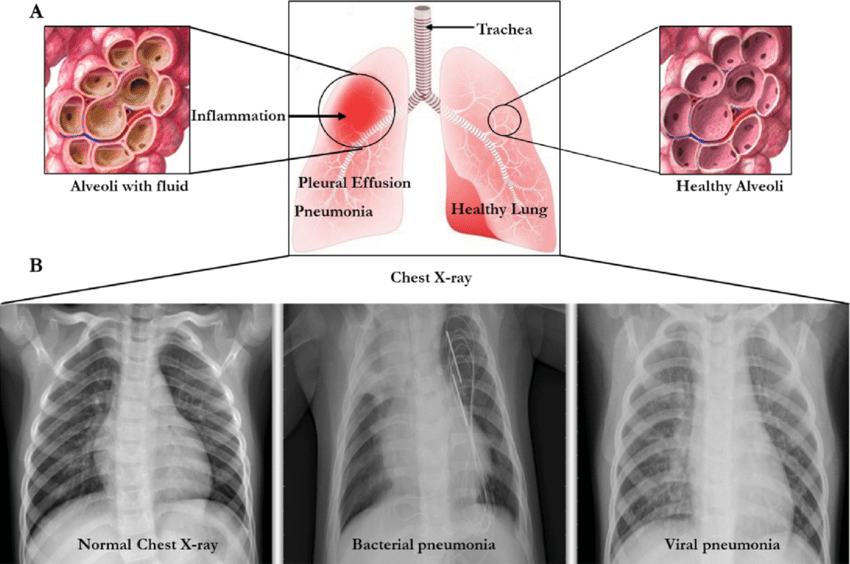

## Settings

In [1]:
import torch
TRAIN_RUN=True
random_seed = 2021
torch.manual_seed(random_seed)
lr = 0.0001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Imports

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
import re
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
import torch
import torch.nn as nn
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import roc_curve, auc

## Get Data

### Download and unzip

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
# path where kaggle.json is present in the Google Drive
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Colab Notebooks/PyTorchPractice"

Mounted at /content/gdrive


In [4]:
!pip install -q kaggle
!kaggle datasets download paultimothymooney/chest-xray-pneumonia -p ./sample_data

100% 2.29G/2.29G [00:54<00:00, 73.4MB/s]
100% 2.29G/2.29G [00:54<00:00, 44.9MB/s]


In [5]:
# !mv chest-xray-pneumonia.zip sample_data/
%cd ./sample_data

/content/sample_data


In [6]:
!unzip -q ./chest-xray-pneumonia.zip -d chest-xray-pneumonia

In [7]:
%cd chest-xray-pneumonia/chest_xray

/content/sample_data/chest-xray-pneumonia/chest_xray


### images catetories

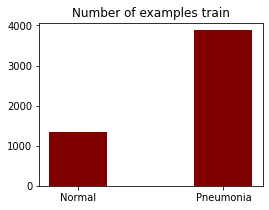

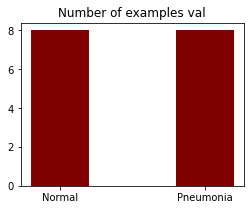

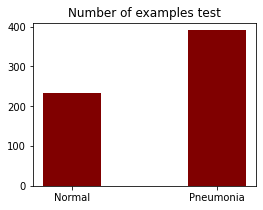

In [8]:
# !ls train/NORMAL/
def get_images(img_path):
    normal_path, pneumonia_path = './'+img_path+'/NORMAL/', './'+img_path+'/PNEUMONIA/'
    normal_images = [normal_path+o.name for o in os.scandir(normal_path) if o.is_file()]
    pneumonia_images = [pneumonia_path+o.name for o in os.scandir(pneumonia_path) if o.is_file()]
    
    fig = plt.figure(figsize = (4, 3))
    # creating the bar plot
    plt.bar(['Normal', 'Pneumonia'], [len(normal_images), len(pneumonia_images)], color ='maroon', width = 0.4)
    plt.title('Number of examples '+img_path)
    plt.show()    
    return normal_images,pneumonia_images

train_images_0,train_images_1 = get_images('train')
train_images = train_images_0 + train_images_1
val_images_0, val_images_1 = get_images('val')
val_images = val_images_0 + val_images_1 
test_images_0, test_images_1 = get_images('test')
test_images = test_images_0 + test_images_1

The given validation set is too small so we'll create bigger one from the training set.

We can see that the training and test set are not balanced - much more Pneumonia examples than normal examples

### Show samples

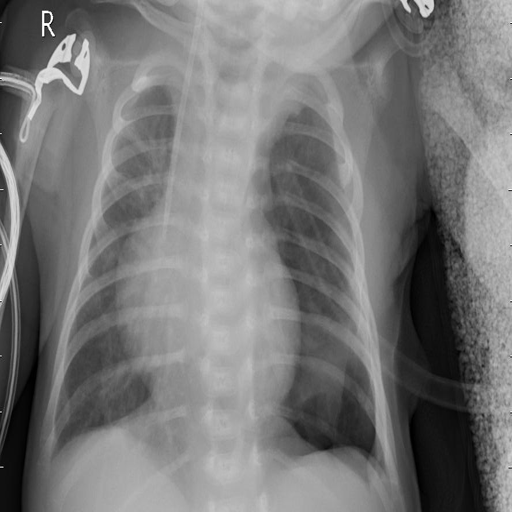

In [9]:
img = Image.open(train_images[-1])  
img.resize((512,512))

The 'R' is a marker that shows the left-right oreintation of the patient. It shouln't bother the model's task.

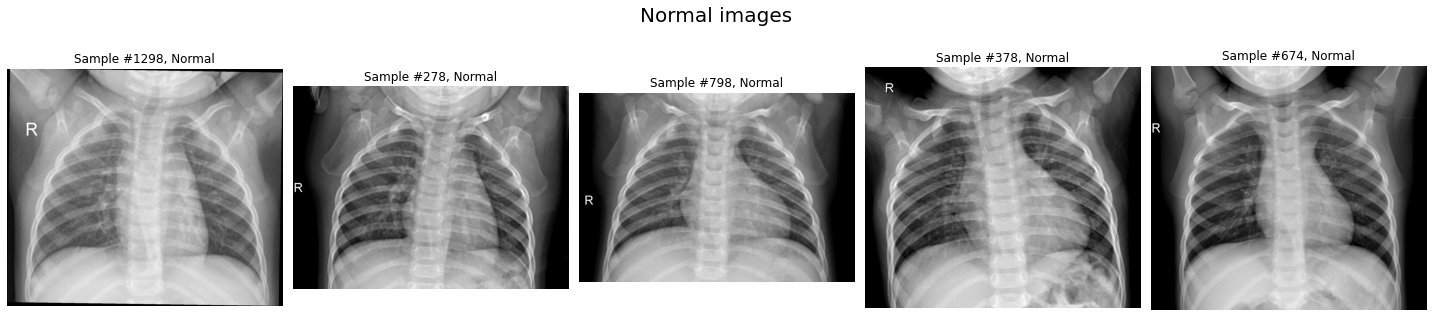

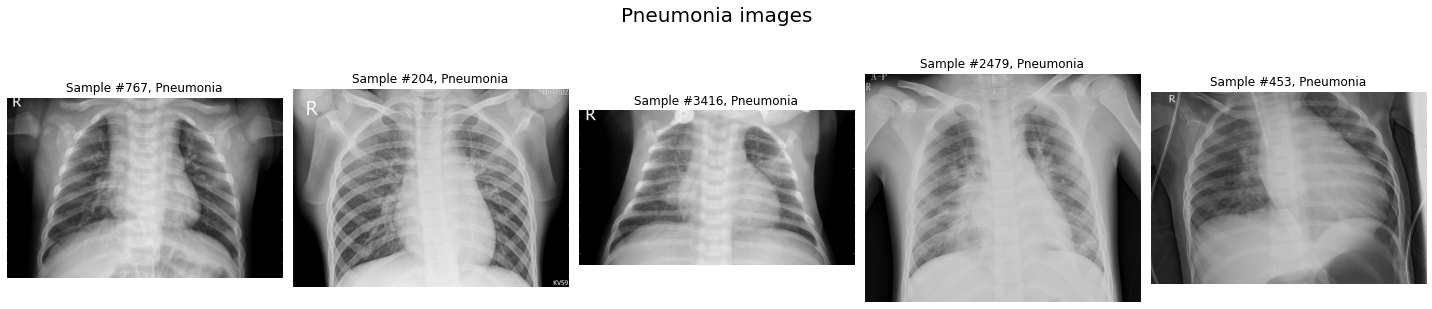

In [10]:
def is_Pneumonia(path):
    return re.search("PNEUMONIA", path) != None

def show_images(image_list, number, title=None):    
    fig = plt.figure(figsize=(min(number,5)*4,5*number//5))
    fig.suptitle(title, fontsize=20)
    for i in range(number):
        img_inx = random.randrange(len(image_list))
        if isinstance(image_list[img_inx], str):
            img = Image.open(image_list[img_inx])
            img = np.asarray(img)
            img_class = 'Pneumonia' if is_Pneumonia(image_list[img_inx]) else 'Normal'
        else: 
            img = image_list[img_inx][0]
            img_class = image_list[img_inx][1]
        ax = fig.add_subplot(number//5, min(number,5), i + 1)        
        
        ax.set_title('Sample #{}, {}'.format(img_inx, img_class))
        plt.axis('off')
        fig.tight_layout()

        if img.ndim == 3 and img.shape[0] > 1:
            if type(img) == torch.Tensor:
                plt.imshow(img.permute(1, 2, 0), )    
            else:
                plt.imshow(img, )    
        else:
            plt.imshow(img.squeeze(), cmap='gray',)                     
    plt.show()

show_images(train_images_0, 5, 'Normal images')
show_images(train_images_1, 5, 'Pneumonia images')

## Create Dataset and Dataloader

In [11]:
class xray_Dataset():
    def __init__(self, filelist, transform = None):        
        # super().__init__(self)
        self.filelist = filelist        
        self.transform = transform

    def __len__(self): return int(len(self.filelist))

    def __getitem__(self,index):
        imgpath = self.filelist[index]
        img = Image.open(imgpath)
        if self.transform is not None: img = self.transform(img)        
        else: img = transforms.ToTensor()(img)
        if img.ndim==3 and img.shape[0] != 3:
            img = img.repeat(3, 1, 1)
        img = img.to(device)

        label = int(re.search("PNEUMONIA", imgpath) != None)        
        label = torch.tensor(label).long().to(device)
        
        return (img,label)        

In [12]:
def show_batch_images(image_list, number, title=None):    
    fig = plt.figure(figsize=(min(number,5)*4,5*number/5))
    fig.suptitle(title, fontsize=20)
    for i in range(number):                
        if len(image_list[0])==2: # dataset case
            img_inx = random.randrange(len(image_list))
            img, img_class = image_list[img_inx][0], image_list[img_inx][1]
        else:                      # dataloader case
            img_inx = random.randrange(len(image_list[0]))
            img, img_class = image_list[0][img_inx], image_list[1][img_inx]
        ax = fig.add_subplot(number/5, min(number,5), i + 1)                
        class_name = 'Pneumonia' if img_class else 'Normal'
        ax.set_title('Sample #{}, {}'.format(img_inx, class_name))
        plt.axis('off')
        fig.tight_layout()
        if isinstance(img,torch.Tensor):
            plt.imshow(img.cpu().permute(1, 2, 0), )    
        else:
            print(img_inx,img)

    plt.show()

In [13]:
## basic transforms 
basic_data_transform = transforms.Compose([
    transforms.Resize(size=(256,256)),    
    transforms.RandomCrop(224),    
    transforms.ToTensor()
])

# for validation and test sets
test_data_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor()
])


In [14]:
# split 80/20
train_split = 0.8
split_vals = [int(train_split*len(train_images)), len(train_images) - int(train_split*len(train_images))]
train_set,val_set = torch.utils.data.random_split(train_images, split_vals)
train_ds = xray_Dataset(train_set, basic_data_transform)
val_ds = xray_Dataset(val_set, test_data_transform)
test_ds = xray_Dataset(test_images, test_data_transform)

## Dataloader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True, num_workers=0)

len(train_ds), len(val_ds)

(4172, 1044)

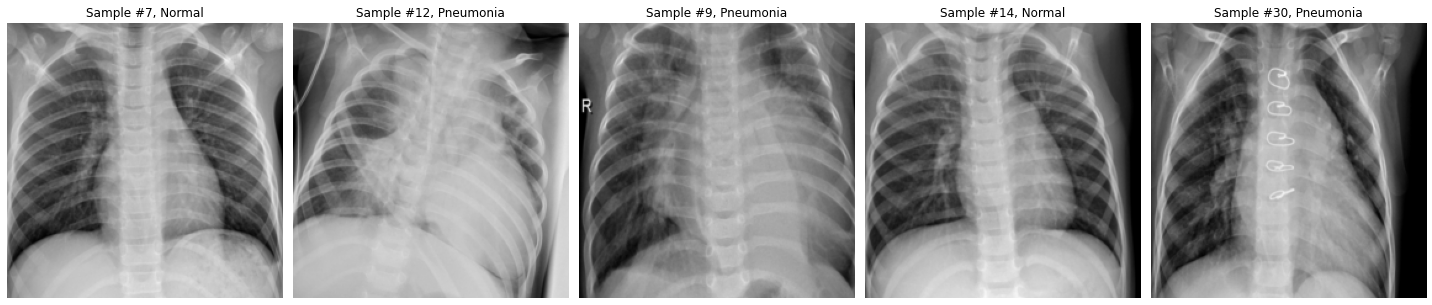

In [15]:
show_batch_images(iter(train_dl).next(), 5, title=None)

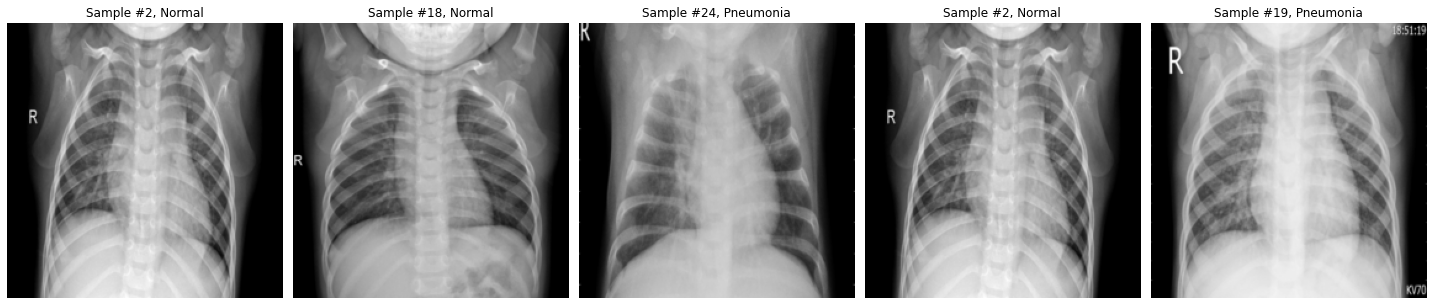

In [16]:
show_batch_images(iter(val_dl).next(), 5, title=None)

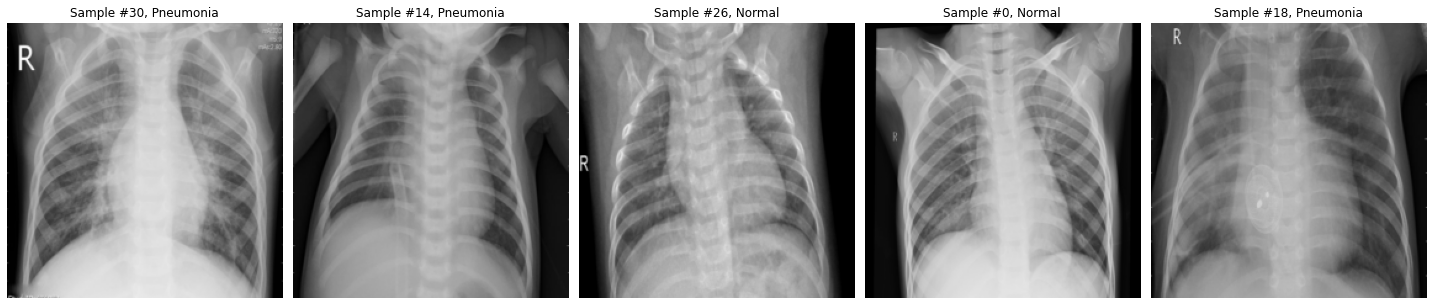

In [17]:
show_batch_images(iter(test_dl).next(), 5, title=None)

## 1. Base Model
pretrained ResNet18 without transformations

In [21]:
def get_resnet_model():
    resnet_model = models.resnet18(pretrained = True)
    # set clasifier for 2 outputs
    num_ftrs = resnet_model.fc.in_features    
    resnet_model.fc = nn.Sequential(
                                    nn.Linear(num_ftrs, 2),
                                    nn.LogSoftmax(dim=-1)  
    )
    resnet_model = resnet_model.to(device)
    return resnet_model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_model = get_resnet_model()

## Define Fit

In [22]:
model = get_resnet_model()
lr=0.0001
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def res_func(pred, thrsh=0.5):       
    return (np.exp(pred) > thrsh)*1

def f1_metric(pred, gt, thrsh=0.5):            
    result = res_func(pred[:,1], thrsh=thrsh)
    return f1_score(gt, result)


In [23]:
from sklearn.metrics import f1_score

def train(dataloader_train):
    total_loss = 0; itr=0; total_f1=0
    p_itr = 20
    model.train()
    for samples, labels in dataloader_train:         
        optimizer.zero_grad() # zero the parameter gradients
        # forward + backward + optimize
        output = model(samples)
        loss = criterion(output, labels.long())        
        loss.backward()
        optimizer.step()
        loss = loss.item()
        total_loss += loss        
        f1 = f1_metric(output.detach().cpu(), labels.cpu())
        total_f1 += f1        
        # print statistics every p_itr iterations        
        itr += 1
        if itr % p_itr == 0:
            print('Iteration {} -> Train Loss: {:.4f}, F1: {:.4f}'\
                    .format(itr, loss, f1))           

    total_loss /= len(dataloader_train)
    total_f1 /= len(dataloader_train)
    return (total_loss, total_f1)                  

def eval(dataloader_val):    
    total_loss = 0; f1=0; total_f1=0
    model.eval()
    with torch.no_grad():
        for samples, labels in dataloader_val:
            output = model(samples)
            loss = criterion(output, labels.long())            
            total_loss += loss.item()        
            f1 = f1_metric(output.cpu(), labels.cpu())
            total_f1 += f1
    total_f1 /= len(dataloader_val)      
    total_loss /= len(dataloader_val)
    return (total_loss, total_f1)
 

def visualize(train_loss_list, train_f1_list, val_loss_list, val_f1_list):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(12,5)
    ax1.plot(train_loss_list, label='train loss')
    ax1.plot(val_loss_list, label='val loss')    
    ax1.set_title('Training and validation loss')    
    ax1.legend()    
    ax2.plot(train_f1_list, label='train F1')    
    ax2.plot(val_f1_list, label='val F1')    
    ax2.set_title('Training and Validation F1')
    ax2.legend()


def fit(dataloader_train, dataloader_val, epochs=3):              
    train_loss_list, val_loss_list = [], []
    train_f1_list, val_f1_list = [], []    
    for epoch in range(epochs):
        
        (train_loss, train_f1) = train(dataloader_train)
        train_loss_list.append(train_loss)
        train_f1_list.append(train_f1)
        
        (val_loss, val_f1) = eval(dataloader_val) 
        val_loss_list.append(val_loss)
        val_f1_list.append(val_f1)             

        print('[Epoch {}/{}] -> Train Loss: {:.4f} train F1: {:.4f}'\
        .format(epoch+1, epochs, train_loss, train_f1),\
        'Val Loss: {:.4f}, val F1: {:.4f}'.format(val_loss, val_f1))  

    print('Finished Training')
    visualize(train_loss_list, train_f1_list, val_loss_list, val_f1_list)


#### Metric Used - F1

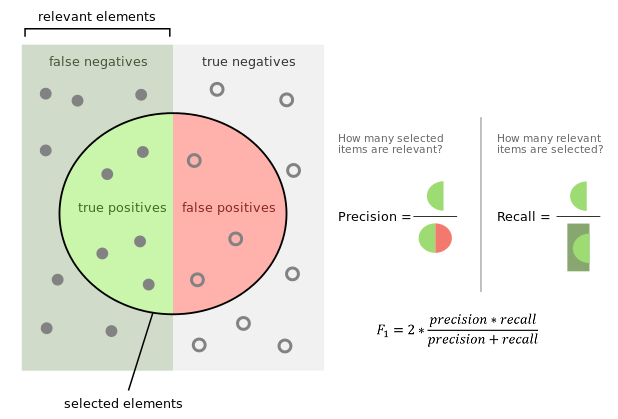

## Train base model


### learning rate finder
example taken from https://github.com/davidtvs/pytorch-lr-finder/blob/master/examples/lrfinder_cifar10_dataloader_iter.ipynb


In [25]:
pip install torch-lr-finder -q


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.98E-05


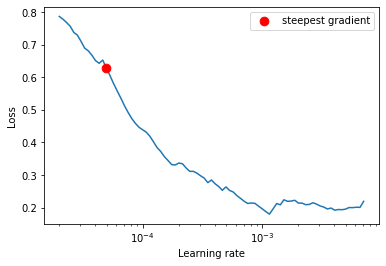

In [36]:
from torch_lr_finder import LRFinder, TrainDataLoaderIter

criterion = nn.NLLLoss()
model = get_resnet_model()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
trainloader = train_dl

class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return batch_data[0], batch_data[1]
    
custom_train_iter = CustomTrainIter(trainloader)

lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(custom_train_iter, start_lr=0.00001, end_lr=0.01, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

We'll use learning rate of 0.0001

### Basic model train

Iteration 20 -> Train Loss: 0.1011, F1: 0.955
Iteration 40 -> Train Loss: 0.0879, F1: 0.979
Iteration 60 -> Train Loss: 0.0332, F1: 1.000
Iteration 80 -> Train Loss: 0.0167, F1: 1.000
Iteration 100 -> Train Loss: 0.0559, F1: 0.980
Iteration 120 -> Train Loss: 0.0073, F1: 1.000
[Epoch 1/5] -> Train Loss: 0.1072 train F1: 0.973 Val Loss: 0.6237, val F1: 0.859
Iteration 20 -> Train Loss: 0.0378, F1: 1.000
Iteration 40 -> Train Loss: 0.0581, F1: 0.979
Iteration 60 -> Train Loss: 0.0563, F1: 0.981
Iteration 80 -> Train Loss: 0.0941, F1: 0.976
Iteration 100 -> Train Loss: 0.0376, F1: 1.000
Iteration 120 -> Train Loss: 0.0118, F1: 1.000
[Epoch 2/5] -> Train Loss: 0.0503 train F1: 0.988 Val Loss: 0.2655, val F1: 0.922
Iteration 20 -> Train Loss: 0.0061, F1: 1.000
Iteration 40 -> Train Loss: 0.0121, F1: 1.000
Iteration 60 -> Train Loss: 0.0879, F1: 0.974
Iteration 80 -> Train Loss: 0.0010, F1: 1.000
Iteration 100 -> Train Loss: 0.0047, F1: 1.000
Iteration 120 -> Train Loss: 0.0077, F1: 1.000
[E

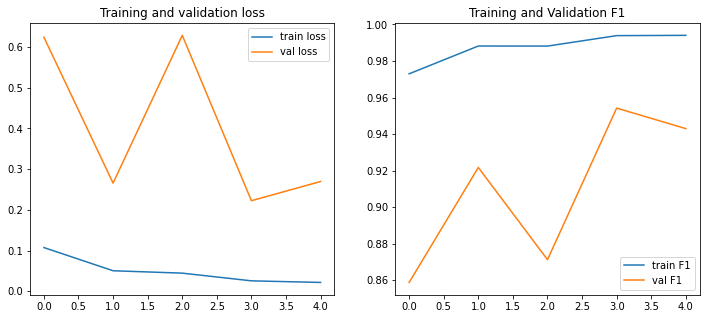

In [37]:
if TRAIN_RUN:
    model = get_resnet_model()    
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)        
    fit(train_dl, test_dl, epochs=5)

## Test Functions

In [24]:
def test_model(model, test_dl, thrsh=0.5):
    expected=[]; predicted=[]
    model.eval()
    with torch.no_grad():
        for samples, labels in test_dl:
            samples, labels = samples.to(device), labels.to(device)                    
            output = model(samples)                          
            pred = output      
            expected.extend(labels.tolist())
            predicted.extend(pred.tolist())
    return np.array(expected), np.array(predicted)[:,1]

In [25]:
# Example of a confusion matrix in Python
from sklearn.metrics import confusion_matrix
def calc_confusion_matrix(expected, predicted):
    round_predicted = res_func(predicted, thrsh=0.5)  
    confusion_mtrx_results = confusion_matrix(expected, round_predicted)    
    tn, fp, fn, tp = confusion_mtrx_results.ravel() 
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))
    print(f"\nPneumonia: precision={precision:.4}  recall={recall:.4}  f1: {f1:.4f}")        
    precision = tn/(tn+fn)
    recall = tn/(tn+fp)    
    f1 = 2*((precision*recall)/(precision+recall))    
    print(f"\nNormal: precision={precision:.4}  recall={recall:.4}  f1: {f1:.4f}")
    accuracy = (tn+tp)/(tn+ fp+ fn+ tp)
    print(f"\nAccuracy: {accuracy*100:.2f}%\n")
    return confusion_mtrx_results

In [26]:
import seaborn as sn
import pandas as pd
def show_confusion_matrix(results):    
    plt.figure(figsize=(8,6))
    sn.set(font_scale=1.4) # for label size
    text = np.asarray([['TN', 'FP'], ['FN', 'TP']])
    labels = (np.asarray(["{0}\n{1:d}".format(text,data) for text, data in zip(text.flatten(), results.flatten())])).reshape(2,2)
    sn.heatmap(results, annot=labels, annot_kws={"size": 16}, fmt='',  xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])     
    plt.xlabel("Predicated labels")
    plt.ylabel("True labels")


In [27]:
def plot_roc(expected, predicted):
    #Calculating the FPR and TPR
    fpr, tpr, thresholds = roc_curve(expected, np.exp(predicted))
    roc_auc = auc(fpr, tpr)
    #Plotting the figure
    plt.figure(figsize = (10,6))
    plt.plot(fpr, tpr, color='red', label=f'ROC, AUC={roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

## 1. Test Base Model

In [46]:
SAVED_MODEL_PATH = '/content/gdrive/MyDrive/Colab Notebooks/PyTorchPractice/xray_pneumonia_model1.pth'
def save_model(model):
    torch.save(model, SAVED_MODEL_PATH)
def load_model(model):
    model = torch.load(SAVED_MODEL_PATH, map_location=torch.device(device))    

if TRAIN_RUN:    
    save_model(model)
else:        
    model = get_resnet_model()
    load_model(model)

_ = model.eval()  

In [47]:
expected, predicted = test_model(model, test_dl)

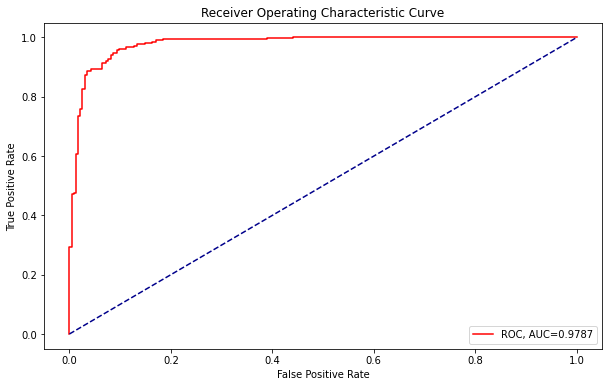

In [48]:
plot_roc(expected, predicted)

In [49]:
results = calc_confusion_matrix(expected, predicted)


Pneumonia: precision=0.9042  recall=0.9923  f1: 0.9462

Normal: precision=0.9847  recall=0.8248  f1: 0.8977

Accuracy: 92.95%



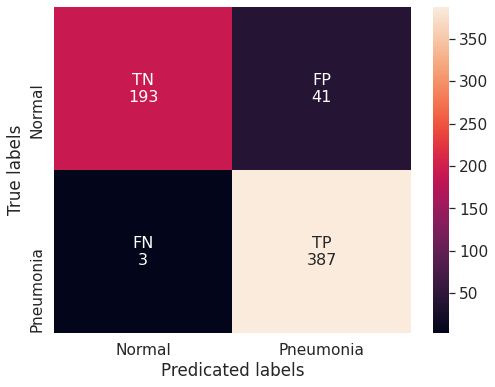

In [50]:
show_confusion_matrix(results)

Since the training data is imbalanced, the model tends to learn better clasification of the mojority class therefore the Normal recall value is reletevly low, as well as the  Pneumonia presicion.
Next, we will try to improve the biased results using 2 methods:
* class weights - weight the loss in order to compensate for the imbalanced data
* oversampling - create trianing data such that the data is balanced. this is done by resampling the imbalaced data so that the classes will be balanced. the rare class will be sampled more than once.

## 2. Add Data augmenatation


In [39]:
data_transform = transforms.Compose([        
    transforms.Resize(size=(256,256)),        
    transforms.ColorJitter(brightness=0.2, contrast=0, saturation=0, hue=0),
    transforms.RandomRotation(degrees=10), #expand=True        
    transforms.RandomAffine(translate=(0.05,0.05), degrees=0),
    transforms.GaussianBlur(3),    
    transforms.RandomCrop(224),            
    transforms.ToTensor()
])

**Common pitfall** - random flip is not a good tranformation since the chest is not symmetrical



In [54]:
train_ds = xray_Dataset(train_set, data_transform)
val_ds = xray_Dataset(val_set, test_data_transform)
test_ds = xray_Dataset(test_images, test_data_transform)

## Dataloader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)

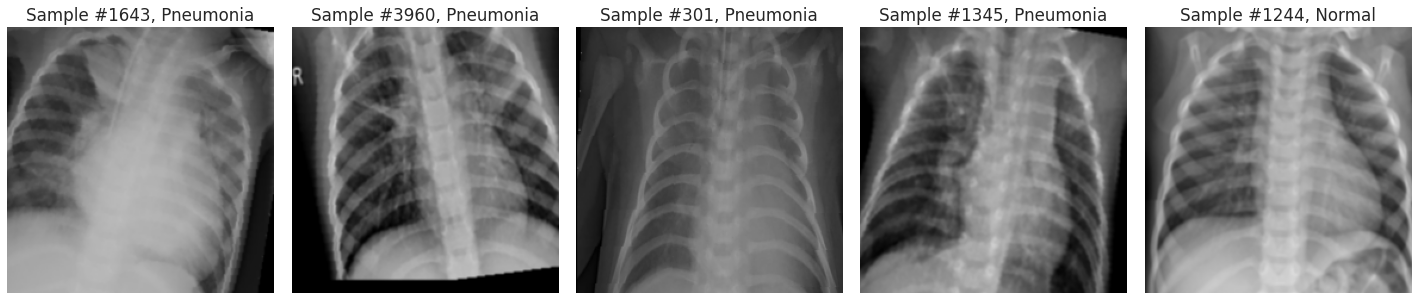

In [60]:
show_batch_images(train_ds, 5)

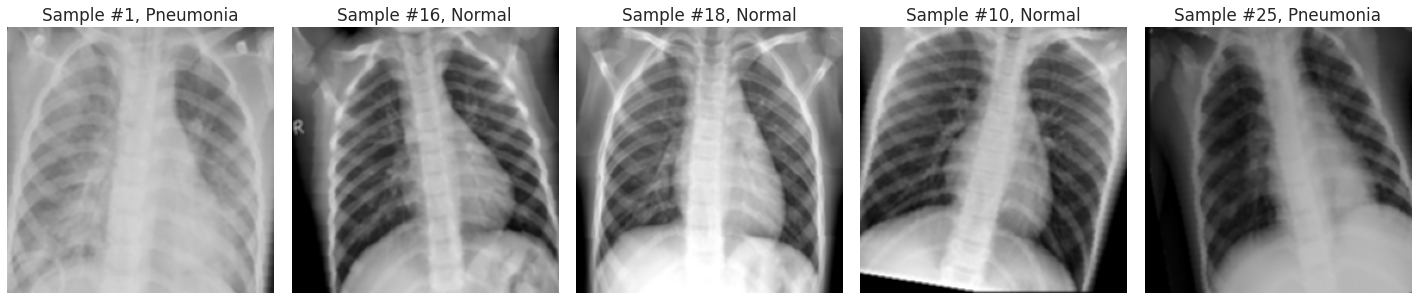

In [61]:
show_batch_images(iter(train_dl).next(), 5, title=None)

In [62]:
model = get_resnet_model()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Iteration 20 -> Train Loss: 0.2331, F1: 0.913
Iteration 40 -> Train Loss: 0.0198, F1: 1.000
Iteration 60 -> Train Loss: 0.1000, F1: 0.981
Iteration 80 -> Train Loss: 0.2887, F1: 0.945
Iteration 100 -> Train Loss: 0.2236, F1: 0.950
Iteration 120 -> Train Loss: 0.0591, F1: 0.979
[Epoch 1/5] -> Train Loss: 0.1562 train F1: 0.949 Val Loss: 0.0884, val F1: 0.971
Iteration 20 -> Train Loss: 0.0943, F1: 0.976
Iteration 40 -> Train Loss: 0.0430, F1: 0.980
Iteration 60 -> Train Loss: 0.0348, F1: 1.000
Iteration 80 -> Train Loss: 0.0290, F1: 1.000
Iteration 100 -> Train Loss: 0.1667, F1: 0.930
Iteration 120 -> Train Loss: 0.1167, F1: 0.978
[Epoch 2/5] -> Train Loss: 0.0741 train F1: 0.981 Val Loss: 0.0758, val F1: 0.982
Iteration 20 -> Train Loss: 0.0530, F1: 0.976
Iteration 40 -> Train Loss: 0.0052, F1: 1.000
Iteration 60 -> Train Loss: 0.1417, F1: 0.978
Iteration 80 -> Train Loss: 0.1011, F1: 0.964
Iteration 100 -> Train Loss: 0.0037, F1: 1.000
Iteration 120 -> Train Loss: 0.0149, F1: 1.000
[E

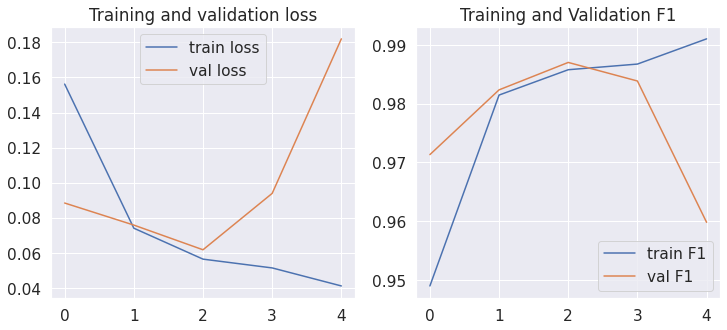

In [63]:
fit(train_dl, val_dl, epochs=5)

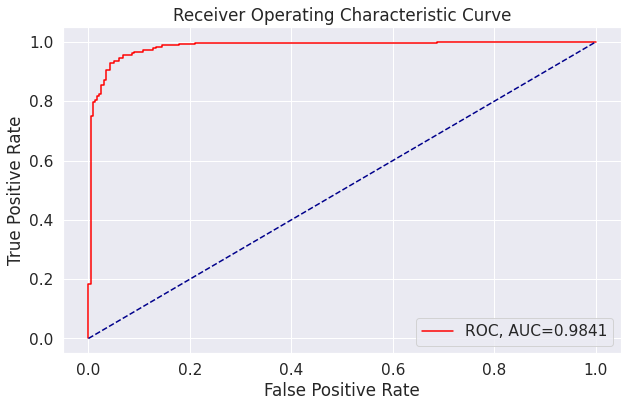


Pneumonia: precision=0.938  recall=0.9692  f1: 0.9533

Normal: precision=0.9457  recall=0.8932  f1: 0.9187

Accuracy: 94.07%



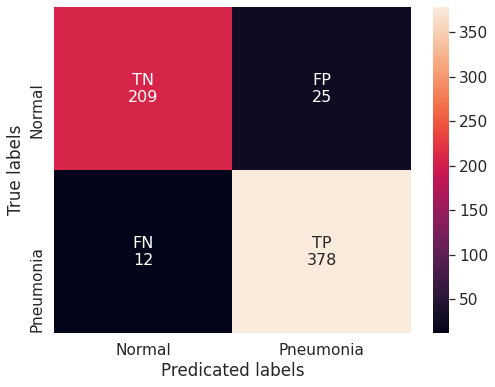

In [64]:
expected, predicted = test_model(model, test_dl)
plot_roc(expected, predicted)
results = calc_confusion_matrix(expected, predicted)
show_confusion_matrix(results)

We can see the results slightly improved, on the F1 values as well as the AUC value.
And yet We can still see that the 'Normal' category has worse performance than the Pneumonia performance, due to the imbalanced training data.

## 3. Set Class weights
weights are oposite to the distribution to balance back the loss with the imbalanced data



the weights are calculated as follows:

wj=n_samples / (n_classes * n_samplesj)

wj is the weight for each class(j signifies the class)
n_samplesis the total number of samples or rows in the dataset
n_classesis the total number of unique classes in the target
n_samplesjis the total number of rows of the respective class

In [71]:
train_normal_count, train_pnoeumania_count = (len(train_images_0),len(train_images_1))
print(train_normal_count, train_pnoeumania_count)
sum_train = train_normal_count + train_pnoeumania_count
weight_for_Normal = (1 / train_normal_count) * (sum_train / 2.0)
weight_for_Pnoeumania = (1 / train_pnoeumania_count) * (sum_train / 2.0)
weight = torch.Tensor([weight_for_Normal, weight_for_Pnoeumania])
print(f'Weights: {weight}')

1341 3875
Weights: tensor([1.9448, 0.6730])


In [72]:
train_ds = xray_Dataset(train_set, data_transform)
val_ds = xray_Dataset(val_set, test_data_transform)
test_ds = xray_Dataset(test_images, test_data_transform)

## Dataloader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)

In [73]:
model = get_resnet_model()
weight = weight.to(device)
criterion = nn.NLLLoss(weight=weight)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Iteration 20 -> Train Loss: 0.1752, F1: 0.950
Iteration 40 -> Train Loss: 0.0184, F1: 1.000
Iteration 60 -> Train Loss: 0.4008, F1: 0.913
Iteration 80 -> Train Loss: 0.0748, F1: 0.978
Iteration 100 -> Train Loss: 0.0375, F1: 1.000
Iteration 120 -> Train Loss: 0.0835, F1: 0.960
[Epoch 1/5] -> Train Loss: 0.1587 train F1: 0.954 Val Loss: 0.0801, val F1: 0.975
Iteration 20 -> Train Loss: 0.0467, F1: 0.981
Iteration 40 -> Train Loss: 0.0471, F1: 1.000
Iteration 60 -> Train Loss: 0.0176, F1: 1.000
Iteration 80 -> Train Loss: 0.1503, F1: 0.977
Iteration 100 -> Train Loss: 0.0585, F1: 0.980
Iteration 120 -> Train Loss: 0.0222, F1: 1.000
[Epoch 2/5] -> Train Loss: 0.0726 train F1: 0.981 Val Loss: 0.0737, val F1: 0.982
Iteration 20 -> Train Loss: 0.0043, F1: 1.000
Iteration 40 -> Train Loss: 0.0453, F1: 0.976
Iteration 60 -> Train Loss: 0.0237, F1: 1.000
Iteration 80 -> Train Loss: 0.0041, F1: 1.000
Iteration 100 -> Train Loss: 0.0418, F1: 1.000
Iteration 120 -> Train Loss: 0.0312, F1: 0.977
[E

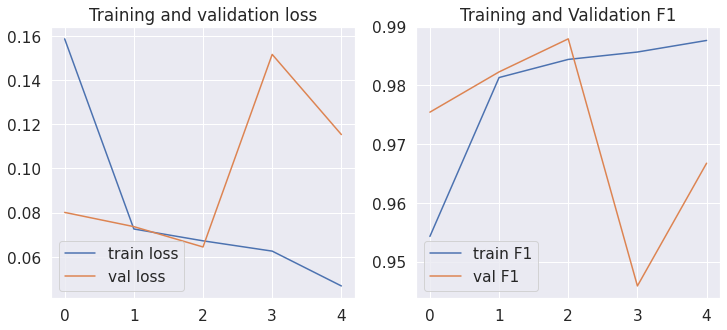

In [74]:
fit(train_dl, val_dl, epochs=5)


Pneumonia: precision=0.9513  recall=0.9513  f1: 0.9513

Normal: precision=0.9188  recall=0.9188  f1: 0.9188

Accuracy: 93.91%



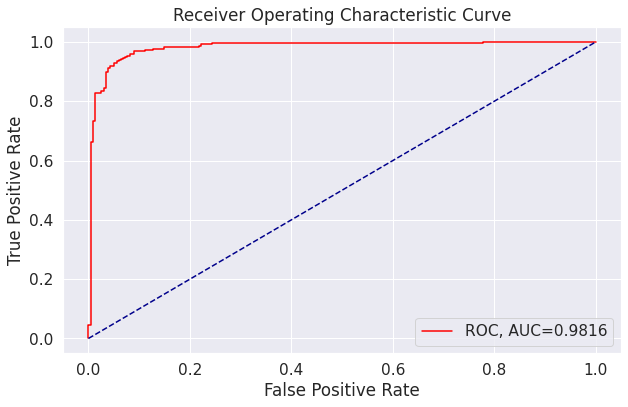

In [76]:
expected, predicted = test_model(model, test_dl)
results = calc_confusion_matrix(expected, predicted)
plot_roc(expected, predicted)


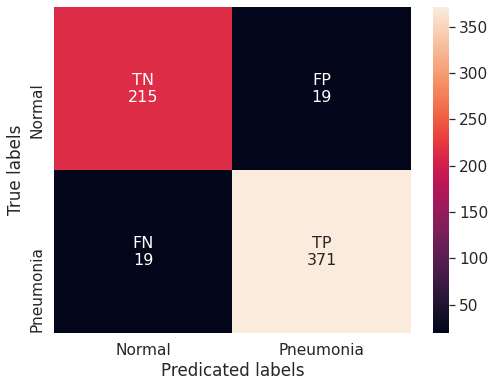

In [77]:
show_confusion_matrix(results)

We can see that the class weights worked well, now the confusion matrix is balanced though the training data is not balanced.

#### show incorrect results

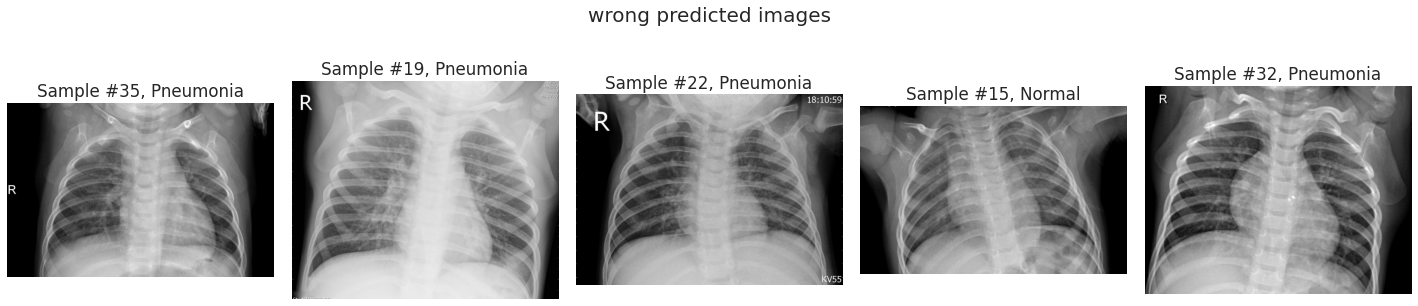

In [78]:
round_predicted = res_func(predicted, thrsh=0.5)
bad_predictions = (np.array(expected) != np.array(round_predicted))
indexes = np.where(bad_predictions)[0]
wrong_test_samples = [test_images[inx] for inx in indexes]
show_images(wrong_test_samples, 5, 'wrong predicted images')

### Visualize network predictions
 Visualize using Grad-CAM for explainability

 Grad-CAM: Gradient-weighted Class Activation Mapping

 https://github.com/jacobgil/pytorch-grad-cam


grad-cam_approach.jpg

In [79]:
!pip -q install grad-cam
!pip -q install ttach

     |████████████████████████████████| 1.8MB 28.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [80]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
model.eval()
gradCamModel = model
target_layer = gradCamModel.layer4[-1]
# input_tensor = test_batch[0]
# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!
# Construct the CAM object once, and then re-use it on many images:
use_cuda = False #True if device is cuda
cam = GradCAM(model=gradCamModel, target_layer=target_layer, use_cuda=use_cuda)

def gradCamVisualization(image_tensor, target_category):
    # If target_category is None, the highest scoring category
    # will be used for every image in the batch.
    # target_category can also be an integer, or a list of different integers
    # for every image in the batch.
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.    
    grayscale_cam = cam(input_tensor=image_tensor, target_category=target_category)
    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    the_img = image_tensor[0,...].permute(1, 2, 0).cpu().numpy()
    visualization = show_cam_on_image(the_img, grayscale_cam, use_rgb=True)
    return visualization

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


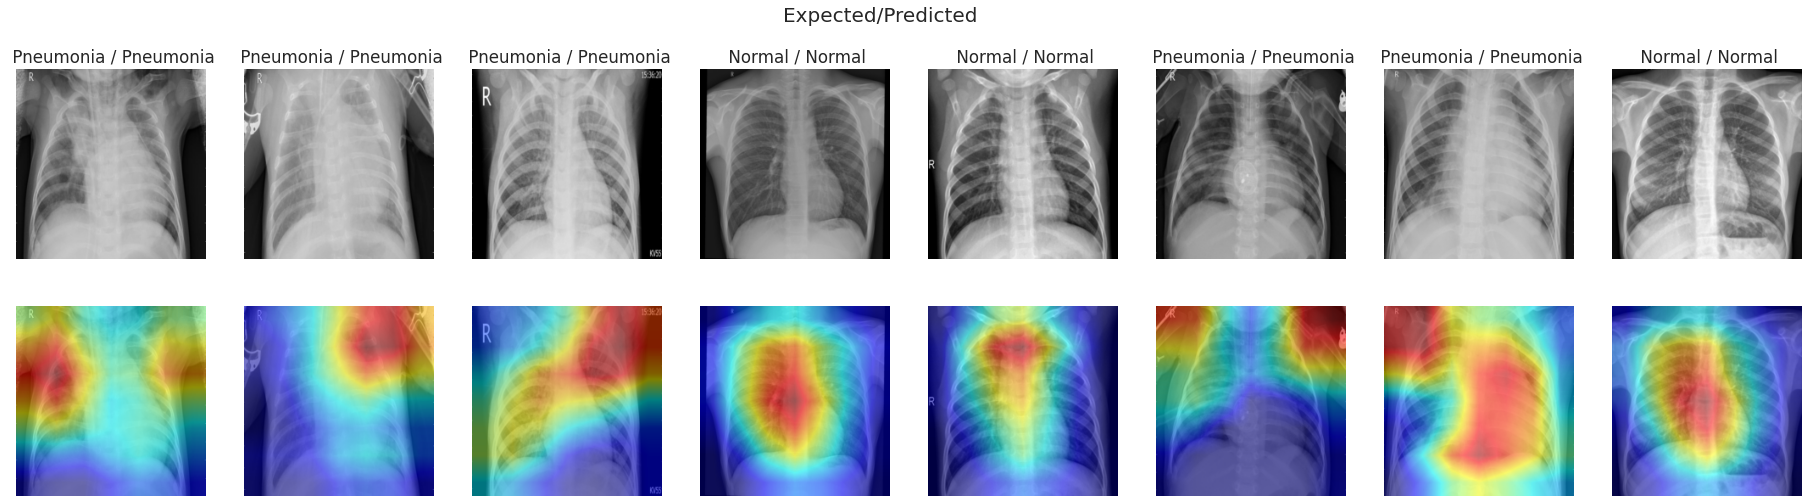

In [84]:
test_dl2 = DataLoader(test_ds, batch_size=8, shuffle=True, num_workers=0)
test_batch = next(iter(test_dl2))
expected, predicted = test_model(model, [test_batch])
predicted_round = res_func(predicted, thrsh=0.5)
image_list = test_batch

fig = plt.figure(figsize=(min(8,8)*4,5*8/5))
fig.suptitle('Expected/Predicted', fontsize=20)
for i in range(8):
    img, img_class = image_list[0][i], image_list[1][i]    
    ax1 = fig.add_subplot(2, 8, i + 1)                    
    ax1.imshow(img.permute(1, 2, 0).cpu(), cmap='gray')
    class_name = 'Pneumonia' if img_class else 'Normal'    
    predicted_class = 'Pneumonia' if predicted_round[i] else 'Normal'
    ax1.set_title(' {} / {}'.format(class_name, predicted_class))
    ax1.axis('off')
    tensor_image = img.unsqueeze(0)
    heatmap = gradCamVisualization(tensor_image, [img_class.long()])
    ax2 = fig.add_subplot(2, 8, 8+ i + 1)                    
    ax2.imshow(heatmap)
    ax2.axis('off')

We can see that mostly when the prediction is Pneumonia, the red color, which represent the spatial source of the network decision is on the correct area of the lungs where the Pneumonia seems to be coming from. When predicion is Normal the source of the decision is from the center of the chest, as there is no indication from the lungs since Normal is the absence of Pneumonia and it has no specific location.

## 4. Oversampling
sampling the imbalanced class more for balanced training
now, instead of using weighted classes, we'll deal with the imbalanced data by oversampling the unbalanced class so the training process will be class balanced. 

In [27]:
train_ds = xray_Dataset(train_set, data_transform)
val_ds = xray_Dataset(val_set, test_data_transform)
test_ds = xray_Dataset(test_images, test_data_transform)

In [28]:
label_lst = [int(lable) for image, lable in train_ds]
label_lst.count(0), label_lst.count(1)

(1102, 3070)

In [30]:
label0_cont, label1_cont = label_lst.count(0),label_lst.count(1)
probs = [label1_cont/len(label_lst), label0_cont/len(label_lst)]
weight_lst = [probs[label_lst[inx]] for inx in range(len(label_lst))]
weight_lst[:10] 
sampler = WeightedRandomSampler(torch.DoubleTensor(weight_lst), int(2*label1_cont), replacement=True)

Define DataLoader with the balanced sampler

In [33]:
## Dataloader
train_dl = DataLoader(train_ds, batch_size=32, num_workers=0, sampler=sampler)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)

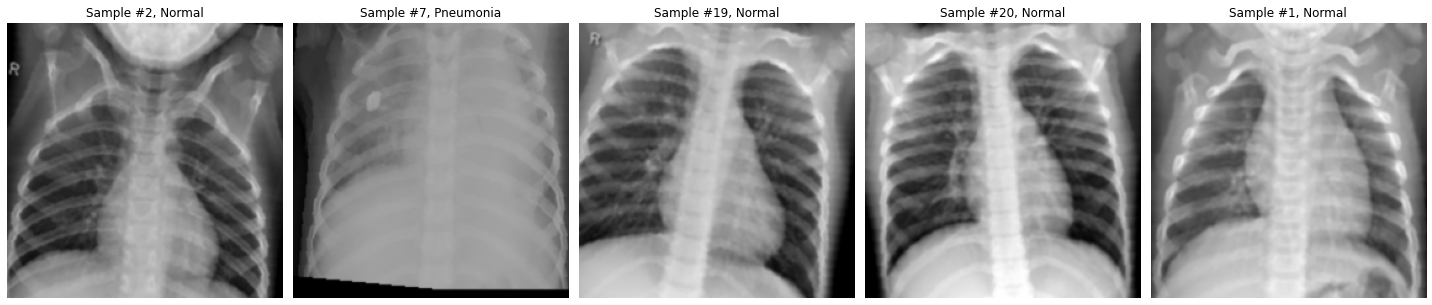

In [42]:
show_batch_images(iter(train_dl).next(), 5, title=None)

In [33]:
model = get_resnet_model()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Iteration 20 -> Train Loss: 0.1956, F1: 0.8667
Iteration 40 -> Train Loss: 0.0930, F1: 0.9714
Iteration 60 -> Train Loss: 0.2882, F1: 0.9474
Iteration 80 -> Train Loss: 0.0120, F1: 1.0000
Iteration 100 -> Train Loss: 0.0315, F1: 1.0000
Iteration 120 -> Train Loss: 0.4828, F1: 0.6000
Iteration 140 -> Train Loss: 0.0109, F1: 1.0000
Iteration 160 -> Train Loss: 0.0615, F1: 0.9744
Iteration 180 -> Train Loss: 0.2665, F1: 0.9730
[Epoch 1/5] -> Train Loss: 0.1131 train F1: 0.9550 Val Loss: 0.0777, val F1: 0.9837
Iteration 20 -> Train Loss: 0.0265, F1: 1.0000
Iteration 40 -> Train Loss: 0.0575, F1: 0.9630
Iteration 60 -> Train Loss: 0.0313, F1: 1.0000
Iteration 80 -> Train Loss: 0.0070, F1: 1.0000
Iteration 100 -> Train Loss: 0.0320, F1: 1.0000
Iteration 120 -> Train Loss: 0.0024, F1: 1.0000
Iteration 140 -> Train Loss: 0.0021, F1: 1.0000
Iteration 160 -> Train Loss: 0.0323, F1: 1.0000
Iteration 180 -> Train Loss: 0.0249, F1: 1.0000
[Epoch 2/5] -> Train Loss: 0.0475 train F1: 0.9834 Val Loss:

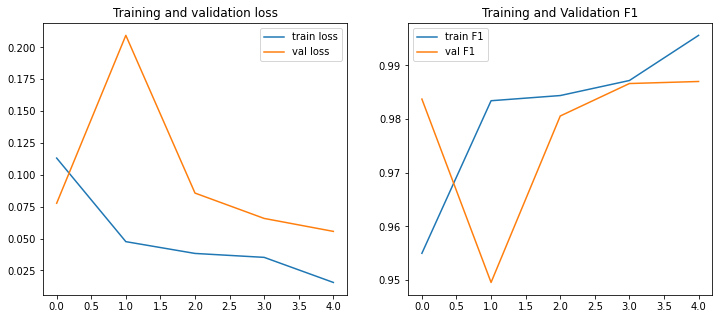

In [34]:
if TRAIN_RUN:
    fit(train_dl, val_dl, epochs=5)


Pneumonia: precision=0.9149  recall=0.9923  f1: 0.9520

Normal: precision=0.9851  recall=0.8462  f1: 0.9103

Accuracy: 93.75%



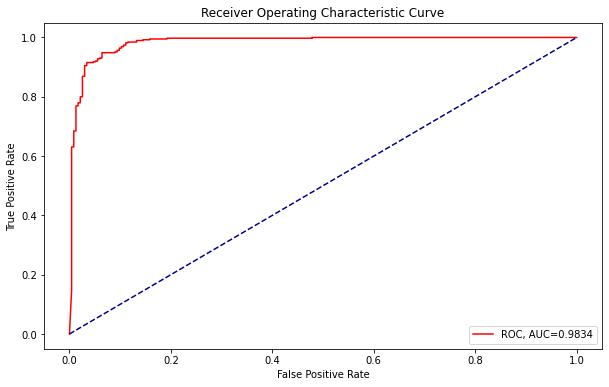

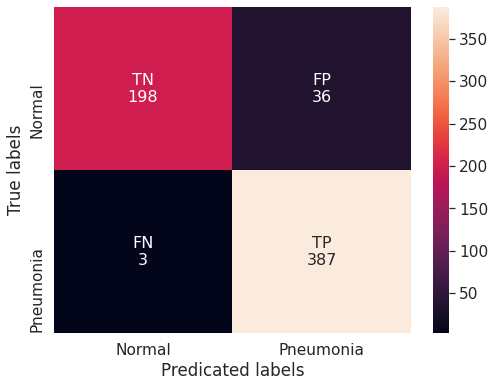

In [35]:
expected, predicted = test_model(model, test_dl)
results = calc_confusion_matrix(expected, predicted)
plot_roc(expected, predicted)
show_confusion_matrix(results)

We can see that there is unbalance in the performance of the 2 classes. the 'Normal' category is still misclassified more though the category training data was oversampled.

# 5. Extreme imbalanced data
In order to see more clearly the outcome of very extremely unbalanced data, in this section this kind of data is created artificially from the Xray data by undersample the Pneumonia category. This scenario of the interesting category as the minority category is common, and we'll see how the methods showen above handling it.


### Dataset and Dataloaders

Normal - 1341 samples 
Pneumonis - 134 samples


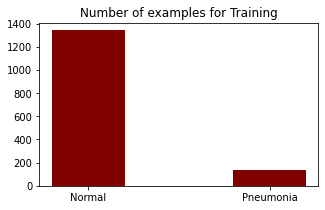

In [37]:
split_vals = [len(train_images_1) - len(train_images_0)//10, len(train_images_0)//10]
_ , train_images_1_reduced = torch.utils.data.random_split(train_images_1, split_vals)
imbalanced_train_images = train_images_1_reduced + train_images_0
print(f'Normal - {len(train_images_0)} samples \n\
Pneumonis - {len(train_images_1_reduced)} samples')
fig = plt.figure(figsize = (5, 3))
# creating the bar plot
plt.bar(['Normal', 'Pneumonia'], [len(train_images_0), len(train_images_1_reduced)], color ='maroon', width = 0.4)
plt.title('Number of examples for Training')
plt.show()

In [40]:
# split training/validation 80/20 
split_vals = [int(0.8*len(imbalanced_train_images)), len(imbalanced_train_images) - int(0.8*len(imbalanced_train_images))]
train_set,val_set = torch.utils.data.random_split(imbalanced_train_images, split_vals)
train_ds = xray_Dataset(train_set, data_transform)
val_ds = xray_Dataset(val_set, test_data_transform)
test_ds = xray_Dataset(test_images, test_data_transform)

## Dataloader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)

### 5.1 Naive training

In [41]:
model = get_resnet_model()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Iteration 20 -> Train Loss: 0.1638, F1: 0.6667
[Epoch 1/5] -> Train Loss: 0.1550 train F1: 0.6916 Val Loss: 0.0684, val F1: 0.7772


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Iteration 20 -> Train Loss: 0.0363, F1: 0.0000
[Epoch 2/5] -> Train Loss: 0.0611 train F1: 0.8212 Val Loss: 0.0438, val F1: 0.8407
Iteration 20 -> Train Loss: 0.0164, F1: 1.0000
[Epoch 3/5] -> Train Loss: 0.0330 train F1: 0.9017 Val Loss: 0.0454, val F1: 0.8296
Iteration 20 -> Train Loss: 0.0081, F1: 1.0000
[Epoch 4/5] -> Train Loss: 0.0600 train F1: 0.8121 Val Loss: 0.0681, val F1: 0.7663
Iteration 20 -> Train Loss: 0.0208, F1: 1.0000
[Epoch 5/5] -> Train Loss: 0.0247 train F1: 0.8803 Val Loss: 0.0797, val F1: 0.7784
Finished Training


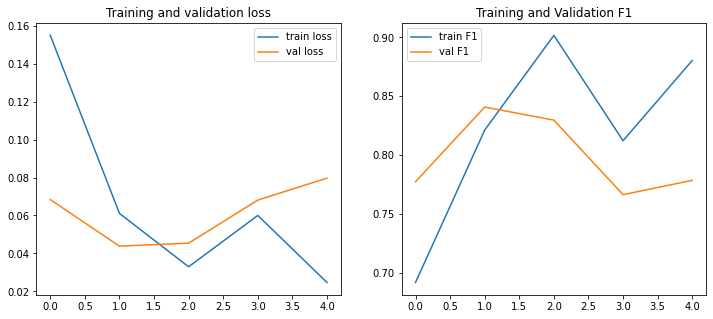

In [42]:
if TRAIN_RUN:
    fit(train_dl, val_dl, epochs=5)

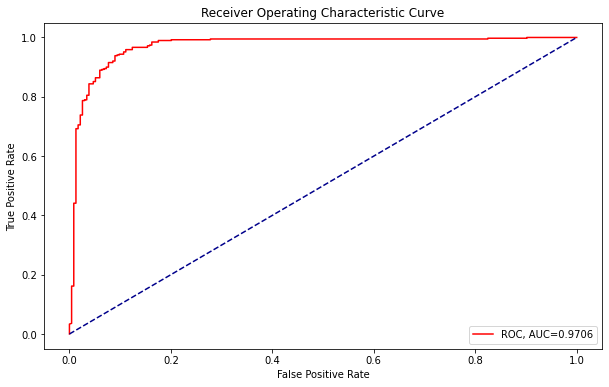


Pneumonia: precision=0.9723  recall=0.8103  f1: 0.8839

Normal: precision=0.7525  recall=0.9615  f1: 0.8443

Accuracy: 86.70%



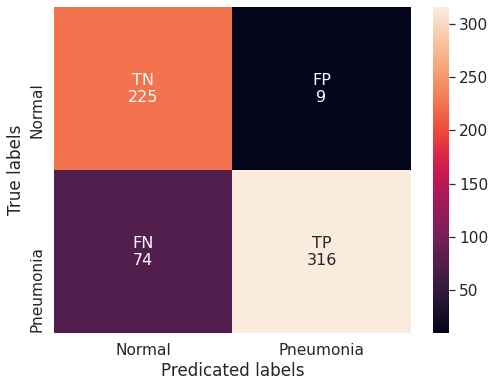

In [43]:
expected, predicted = test_model(model, test_dl)
plot_roc(expected, predicted)
results = calc_confusion_matrix(expected, predicted)
show_confusion_matrix(results)

### 5.2 Class weightning

In [45]:
train_normal_count, train_pnoeumania_count = (len(train_images_0),len(train_images_1_reduced))
print(train_normal_count, train_pnoeumania_count)
sum_train = train_normal_count + train_pnoeumania_count
weight_for_Normal = (1 / train_normal_count) * (sum_train / 2.0)
weight_for_Pnoeumania = (1 / train_pnoeumania_count) * (sum_train / 2.0)
class_weights = torch.Tensor([weight_for_Normal, weight_for_Pnoeumania])
print(f'Weights: {class_weights}')

1341 134
Weights: tensor([0.5500, 5.5037])


In [46]:
model = get_resnet_model()
class_weights = class_weights.to(device)
criterion = nn.NLLLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Iteration 20 -> Train Loss: 0.1399, F1: 0.6667
[Epoch 1/5] -> Train Loss: 0.3307 train F1: 0.5582 Val Loss: 0.4188, val F1: 0.3801
Iteration 20 -> Train Loss: 0.0446, F1: 1.0000
[Epoch 2/5] -> Train Loss: 0.1356 train F1: 0.7690 Val Loss: 0.1240, val F1: 0.9302
Iteration 20 -> Train Loss: 0.0143, F1: 1.0000
[Epoch 3/5] -> Train Loss: 0.0664 train F1: 0.8911 Val Loss: 0.0494, val F1: 0.9306
Iteration 20 -> Train Loss: 0.0172, F1: 1.0000
[Epoch 4/5] -> Train Loss: 0.0577 train F1: 0.9044 Val Loss: 0.1117, val F1: 0.9274
Iteration 20 -> Train Loss: 0.1576, F1: 0.0000
[Epoch 5/5] -> Train Loss: 0.0605 train F1: 0.8341 Val Loss: 0.1825, val F1: 0.9163
Finished Training


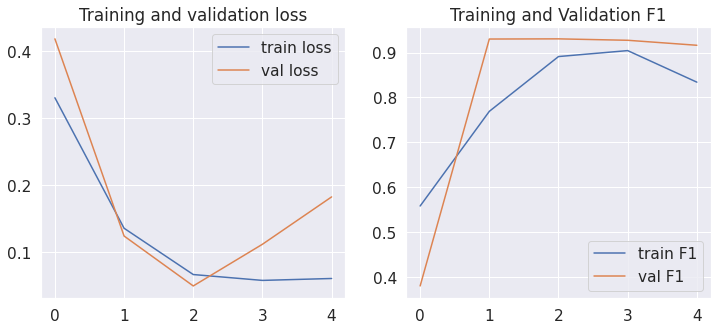

In [47]:
fit(train_dl, val_dl, epochs=5)

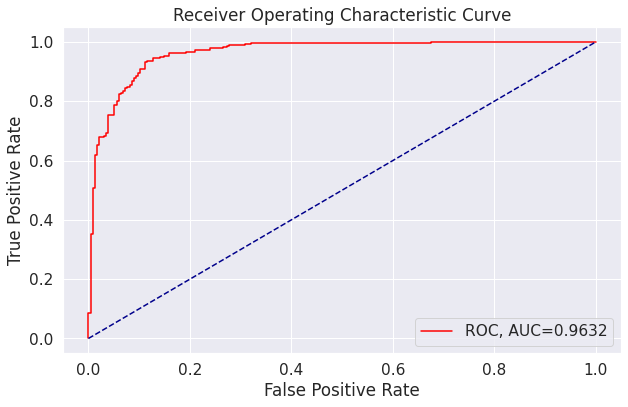


Pneumonia: precision=0.9357  recall=0.8949  f1: 0.9148

Normal: precision=0.8367  recall=0.8974  f1: 0.8660

Accuracy: 89.58%



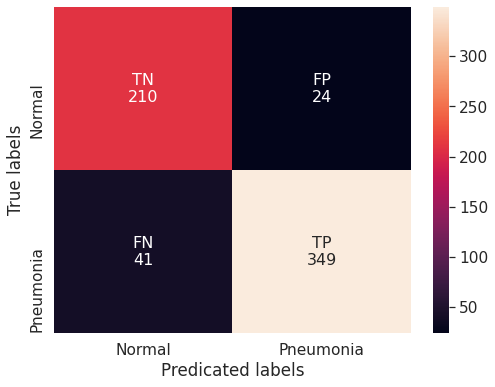

In [48]:
expected, predicted = test_model(model, test_dl)
plot_roc(expected, predicted)
results = calc_confusion_matrix(expected, predicted)
show_confusion_matrix(results)

### 5.3 Oversampling

In [49]:
train_ds = xray_Dataset(train_set, data_transform)
val_ds = xray_Dataset(val_set, test_data_transform)
test_ds = xray_Dataset(test_images, test_data_transform)

In [50]:
label_lst = [int(train_ds[inx][1]) for inx in range(len(train_ds))]
label_lst[:20]
label_lst.count(0), label_lst.count(1)

(1071, 109)

In [56]:
label0_cont, label1_cont = label_lst.count(0),label_lst.count(1)
vals = [label1_cont/len(label_lst), label0_cont/len(label_lst)]
weight_lst = [vals[label_lst[inx]] for inx in range(len(label_lst))]
sampler = WeightedRandomSampler(torch.DoubleTensor(weight_lst), int(2*label0_cont), replacement=True)

Define DataLoader with the balanced sampler

In [58]:
## Dataloader
train_dl = DataLoader(train_ds, batch_size=32, num_workers=0, sampler=sampler)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)

In [59]:
model = get_resnet_model()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Iteration 20 -> Train Loss: 0.0796, F1: 0.9756
Iteration 40 -> Train Loss: 0.0527, F1: 1.0000
Iteration 60 -> Train Loss: 0.1224, F1: 0.9697
[Epoch 1/5] -> Train Loss: 0.1286 train F1: 0.9572 Val Loss: 0.0286, val F1: 0.9746
Iteration 20 -> Train Loss: 0.0117, F1: 1.0000
Iteration 40 -> Train Loss: 0.0251, F1: 1.0000
Iteration 60 -> Train Loss: 0.0052, F1: 1.0000
[Epoch 2/5] -> Train Loss: 0.0329 train F1: 0.9871 Val Loss: 0.0521, val F1: 0.8546
Iteration 20 -> Train Loss: 0.0162, F1: 1.0000
Iteration 40 -> Train Loss: 0.0033, F1: 1.0000
Iteration 60 -> Train Loss: 0.0398, F1: 0.9677
[Epoch 3/5] -> Train Loss: 0.0257 train F1: 0.9923 Val Loss: 0.0326, val F1: 0.9306
Iteration 20 -> Train Loss: 0.2259, F1: 0.8718
Iteration 40 -> Train Loss: 0.0290, F1: 0.9697
Iteration 60 -> Train Loss: 0.0056, F1: 1.0000
[Epoch 4/5] -> Train Loss: 0.0266 train F1: 0.9881 Val Loss: 0.0542, val F1: 0.9302
Iteration 20 -> Train Loss: 0.1496, F1: 0.9524
Iteration 40 -> Train Loss: 0.0206, F1: 1.0000
Iterat

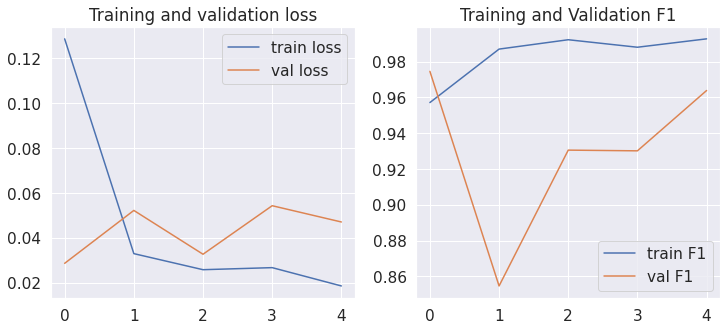

In [60]:
if TRAIN_RUN:
    fit(train_dl, val_dl, epochs=5)


Pneumonia: precision=0.9118  recall=0.9282  f1: 0.9199

Normal: precision=0.8767  recall=0.8504  f1: 0.8633

Accuracy: 89.90%



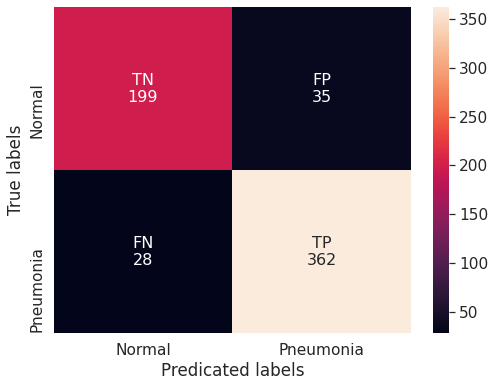

In [61]:
expected, predicted = test_model(model, test_dl)
results = calc_confusion_matrix(expected, predicted)
show_confusion_matrix(results)

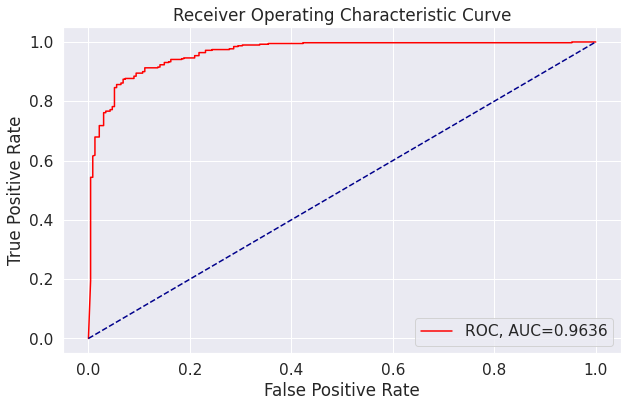

In [62]:
plot_roc(expected, predicted)

# Summary


#### Models comparison
on the given data set we had a minority class of type 'Normal' with 1:3 ratio.
from the table below we can see how using class weigh and data oversampling improved the minority class prediction, as can be seen from the 'Normal recall' values. the class weight had the most siginificant influence compaerd to data oversampling with small influence.

Model and method   | Pneumonia F1 | Normal F1 | Normal recall | AUC
-------------------|--------------|-----------|---------------| ---
1.basic model       | 0.9462 | 0.8977 | 0.8248 | 0.9787 
2.Model with augmentation | 0.9533 | 0.9187 | 0.8932 | 0.9842
3.Model with class weight | 0.9513 | 0.9188 | 0.9188 | 0.9816
4.model with data oversampling | 0.9520 | 0.9103 | 0.8462 | 0.9834


### Extreme imbalanced data
here the Pneumonia is the smaller set with 1:10 ratio of samples.

Model and method   | Pneumonia F1 | Normal F1 | Pneumonia recall | AUC
-------------------|--------------|-----------|---------------| ---
1.basic model        | 0.8839 | 0.8443 | 0.8103 | 0.9706
2.with class weight  | 0.9148 | 0.8660 | 0.8949 | 0.9632
3.with data oversampling | 0.9199 | 0.8633 | 0.9282 | 0.9636

here we can see more cleary that both class weight and data oversampling contribute to significant improvement on the minority class as we can see on the Pneumonia recall value that was improved from 0.81 to about 0.9.